[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ninarina12/NX-School-2023/blob/main/AI-ML_Tutorial.ipynb)

# Introduction to AI-ML Applications for X-ray Experiments

## Background
This tutorial describes an introductory-level AI/ML application to assist an experimental workflow inspired by the work of [Starodub *et al*](https://www.nature.com/articles/ncomms2288). In this work, the authors used ultra-short, intense X-ray pulses from an X-ray free-electron laser (FEL) to obtain single-shot diffraction patterns of polystyrene sphere aggregates. These aggregates vary in size from one to multiple spheres and need to be sorted prior to further analysis.

In this tutorial, we will demonstrate how different machine learning techniques can be used to automate and accelerate this type of workflow, including:
- Building a simple convolutional neural network to classify synthetic diffraction patterns of sphere aggregates by aggregate size (*i.e.* number of spheres).
- Using clustering methods to differentiate and sort diffraction patterns.
- Streamlining the coding process by using ChatGPT to propose code for specific tasks such as generating training data of the target system, building the neural network architecture, and writing a training loop with helpful checkpoints.

### Getting started

If running within Google Colaboratory, make sure you have a GPU runtime selected. Go to Runtime > Change runtime type, and select one of the GPU hardware accelerators.

![background.png](background.png)

## Generation of synthetic objects and diffraction patterns

### Use ChatGPT to make a generator for custom image data

We will use ChatGPT to write a generator for image data resembling the spherical aggregates. For simplicity, we will work in two-dimensions and generate the projection of spherical aggregates on a two-dimensional plane perpendicular to the beam direction.

#### ChatGPT Prompt:
Write a python script using numpy arrays that generates $N \times N$ images with 1-5 randomly-placed circles of a user-provided radius, all of which either touch or overlap one another. Ensure that the first circle is placed within the center $N/2 \times N/2$ pixels of the image.

In [10]:
import numpy as np

def generate_image(N, num_circles, radius):
    if num_circles < 1 or num_circles > 5:
        raise ValueError("Number of circles should be between 1 and 5.")

    # Create an empty NxN image
    image = np.zeros((N, N))

    # Function to generate a circle within an image
    def draw_circle(img, center, rad):
        Y, X = np.ogrid[:img.shape[0], :img.shape[1]]
        dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
        mask = dist_from_center <= rad
        img[mask] = 1

    # Generate the first circle in the center N/2 x N/2 pixels
    center_x = np.random.randint(N/4, 3*N/4)
    center_y = np.random.randint(N/4, 3*N/4)
    centers = [(center_x, center_y)]
    draw_circle(image, centers[0], radius)

    for _ in range(1, num_circles):
        # Randomly select an existing circle
        ref_center = centers[np.random.choice(len(centers))]

        # Generate a random angle to place the new circle
        angle = 2 * np.pi * np.random.rand()

        # Calculate the center of the new circle based on the angle and 2*radius distance
        new_center_x = ref_center[0] + 2 * radius * np.cos(angle)
        new_center_y = ref_center[1] + 2 * radius * np.sin(angle)
        
        # Handle boundaries
        new_center_x = min(max(radius, new_center_x), N - radius)
        new_center_y = min(max(radius, new_center_y), N - radius)

        centers.append((new_center_x, new_center_y))
        draw_circle(image, (new_center_x, new_center_y), radius)

    return image

Below, we define a short custom plotting function in order to visualize examples of the generated images.

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_object(obj, label=0):
    fig, ax = plt.subplots(figsize=(3,3))
    
    ax.imshow(obj, origin='lower', cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    
    if label:
        ax.text(0.9, 0.1, 'n = ' + str(label), color='white', ha='right', va='bottom', transform=ax.transAxes)
        
    return fig

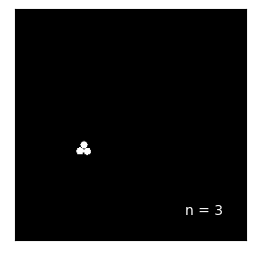

In [12]:
# Generate real-space object
N = 256
num_circles = 3
radius = 4
obj = generate_image(N, num_circles, radius)

# Plot object
fig = plot_object(obj, num_circles)

### Write custom functions to generate diffraction patterns from generated images
The diffracted intensity is well-approximated by the square modulus of the Fourier transform, i.e.
$$ I(\mathbf{q}) = |\mathcal{F}\{\mathcal{O}(\mathbf{r})\}|^2,$$
where $\mathcal{F}$ denotes the Fourier transform.

Experimental data are also often corrupted by Poisson noise; thus, instead of using the perfect calculated diffraction intensity, we can use it to sample from a Poisson distribution in which the intensity acts as a proxy for the expected event frequency, $\lambda$.

To accomplish this in a systematic way, we will first calculate perfect diffraction patterns and normalize them by the maximum intensity value. Then, we will scale the image by the factor $\lambda_{max}$, the maximum expected event frequency, and resample each pixel from the Poisson distribution with $\lambda$ given by the pixel value. The smaller $\lambda_{max}$ is, the noisier the diffraction pattern will be.

In [13]:
def fourier_transform(obj):
    # Perform a 2D FFT
    return np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(obj)))

def calculate_diffraction_pattern(obj, lambda_max=1e3):
    # Calculate the diffracted intensity from a given object, and normalize by the maximum value
    diff = np.abs(fourier_transform(obj))**2
    diff /= diff.max()
    
    # Scale by the maximum expected event frequency (intensity) and corrupt with poisson noise
    return np.random.poisson(lambda_max*diff)

We also add a plotting function for visualizing the object and corresponding diffraction pattern.

In [14]:
def plot_object_and_pattern(obj, diff, label=0):
    fig, ax = plt.subplots(1,3, figsize=(6.25,3), gridspec_kw={'width_ratios': [1,1,0.05]})
    fig.subplots_adjust(wspace=0.1)
    
    cmap = plt.cm.bone
    vmax = 10**np.round(np.log10(diff.max()))
    norm = mpl.colors.LogNorm(vmin=1., vmax=vmax, clip=True)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

    ax[0].imshow(obj, origin='lower', cmap='gray')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    
    if label:
        ax[0].text(0.9, 0.1, 'n = ' + str(label), color='white', ha='right', va='bottom', transform=ax[0].transAxes)

    ax[1].imshow(diff, origin='lower', cmap=cmap, norm=norm)
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    plt.colorbar(sm, cax=ax[2])
    return fig

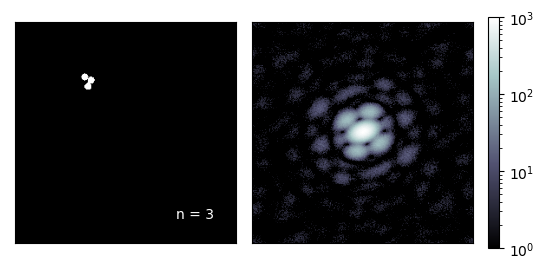

In [15]:
# Generate real-space object
N = 256
num_circles = 3
radius = 4
obj = generate_image(N, num_circles, radius)

# Calculate diffraction pattern
lambda_max = 1e3
diff = calculate_diffraction_pattern(obj, lambda_max)

# Plot pattern
fig = plot_object_and_pattern(obj, diff, num_circles)

### Write a loop to generate a dataset of object images and diffraction patterns
Now we want to construct a large, labeled dataset to be used for machine learning. To do this, we will randomly sample the aggregate size, `num_circles`, at each iteration and then randomly generate the corresponding object and its diffraction pattern. We will also define the class or label of each image as `num_circles - 1` in order to index the classes starting from 0.

In [16]:
from tqdm import tqdm

num_images = 1000
objs = np.zeros((num_images, N, N))
diffs = np.zeros_like(objs)
targets = np.zeros((num_images,), dtype=int)

for i in tqdm(range(num_images), desc="Generating image data"):
    # Randomly select number of circles to generate
    num_circles = np.random.randint(1,6)
    targets[i] = num_circles - 1
    
    # Generate real-space image
    objs[i] = generate_image(N, num_circles, radius)
    
    # Calculate diffraction pattern
    diffs[i] = calculate_diffraction_pattern(objs[i], lambda_max)

Generating image data: 100%|███████████████████████████████████| 1000/1000 [00:03<00:00, 278.32it/s]


We also add a plotting function for visualizing a subset of randomly-selected diffraction patterns from the dataset.

In [17]:
def plot_pattern_grid(diffs, labels=None):
    fig, ax = plt.subplots(4,5, figsize=(8,8), gridspec_kw={'width_ratios': [1]*4 + [0.05]})
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    axes = ax[:,:-1].ravel()

    if len(diffs) <= 16:
        indices = np.arange(len(diffs))
    else:
        indices = np.random.randint(len(diffs), size=16)

    cmap = plt.cm.bone
    vmax = 10**np.round(np.log10(diffs.max()))
    norm = mpl.colors.LogNorm(vmin=1., vmax=vmax, clip=True)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

    for i, index in enumerate(indices):
        axes[i].imshow(diffs[index], origin='lower', cmap=cmap, norm=norm)
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    
    for j in range(i + 1,16):
        axes[j].remove()
        
    for i in range(3):
        ax[i,-1].remove()
    
    try: len(labels)
    except: pass
    else:
        for i, index in enumerate(indices):
            axes[i].text(0.9, 0.1, 'n = ' + str(labels[index]), color='white', ha='right', va='bottom',
                         transform=axes[i].transAxes)
        
    plt.colorbar(sm, cax=ax[-1,-1])
    return fig

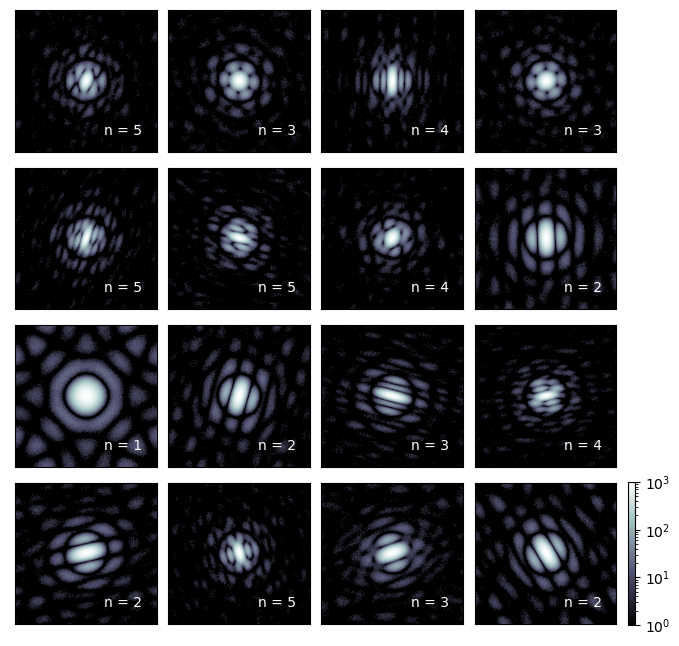

In [18]:
fig = plot_pattern_grid(diffs, targets + 1)

## Exploratory Data Analysis

Scientific data are complex, and x-ray scattering datasets can be extremely large.  Therefore, exploratory data analysis is an important first step to understanding the structure and distribution of your data.

Dimensionality reduction is common first step.
### ChatGPT Prompt:
Please explain the concept fo dimensionality reduction in three bullet points.
### Response:
*Certainly! Dimensionality reduction is a technique used to simplify and represent high-dimensional data in a lower-dimensional space while preserving its essential features. Here's a concise explanation in three bullet points:*

***1. High-Dimensional to Low-Dimensional Transformation:**
Dimensionality reduction involves transforming complex data from a high-dimensional space (many features or variables) to a lower-dimensional space (fewer features or variables). This reduction helps simplify data representation, making it easier to visualize, analyze, and interpret.*

***2. Retaining Relevant Information:**
During dimensionality reduction, the goal is to retain as much meaningful information as possible while discarding or compressing less important or redundant features. This is achieved by identifying patterns, relationships, and correlations among the original features.*

***3. Applications and Benefits:**
Dimensionality reduction is widely used in various fields, such as machine learning, data visualization, and feature engineering. It can lead to faster computations, reduced memory requirements, and improved model performance by mitigating the "curse of dimensionality," where data becomes sparse and models become complex in high dimensions. Popular techniques include Principal Component Analysis (PCA), t-Distributed Stochastic Neighbor Embedding (t-SNE), and autoencoders.*

*In summary, dimensionality reduction simplifies data by transforming it into a lower-dimensional space while retaining crucial information, enabling better understanding, analysis, and modeling of complex datasets.*



We can start by decomposing the sythetic diffraction dataset using PCA to observe any inital trends.

In [19]:
from sklearn.decomposition import PCA

# Initiate PCA model with many components
pca = PCA(n_components=20)

# reshape diffraction data from M X N X N, where M is the number of images and N is the number of pixels to M x N^2 for PCA analysis
diffs_vector = diffs.reshape(diffs.shape[0],diffs.shape[1]*diffs.shape[2]) 

# Fit PCA Model to diffraction data
pca_transform = pca.fit_transform(diffs_vector) 
# this will be a M x n_components matrix where each row corresponds to the transform
# of a single diffraction pattern, and the columns correspond to coefficients of each principal component

Each principal component of a dataset explains some amount of the variance in the dataset.  The components are ordered based on their explained variance ratio, such that the first component explains the largest amount of the dataset, and the highest component number explains the least variance.

The explained variance ratio can be plotted as a function of component number to understand how many components are needed to accurately represent the dataset.

Highly structured datasets can be described by a small number of components.  In these cases, high-numbered components describe noise in the data

In the following plot we see that the first 3 components describe the majority of the variance.

Amount of variance explained by first 3 components: 89.06 %


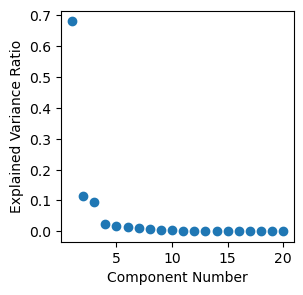

In [24]:
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(np.arange(20)+1,pca.explained_variance_ratio_)
ax.set_xlabel('Component Number')
ax.set_ylabel('Explained Variance Ratio')

print('Amount of variance explained by first 3 components: {} %'.format(np.round(np.sum(pca.explained_variance_ratio_[:3]) * 100,2)))

We can now look at the first three components which describe the majority of the data

### Questions:
- How can we interpret the first few components?  What types of variation do they describe?

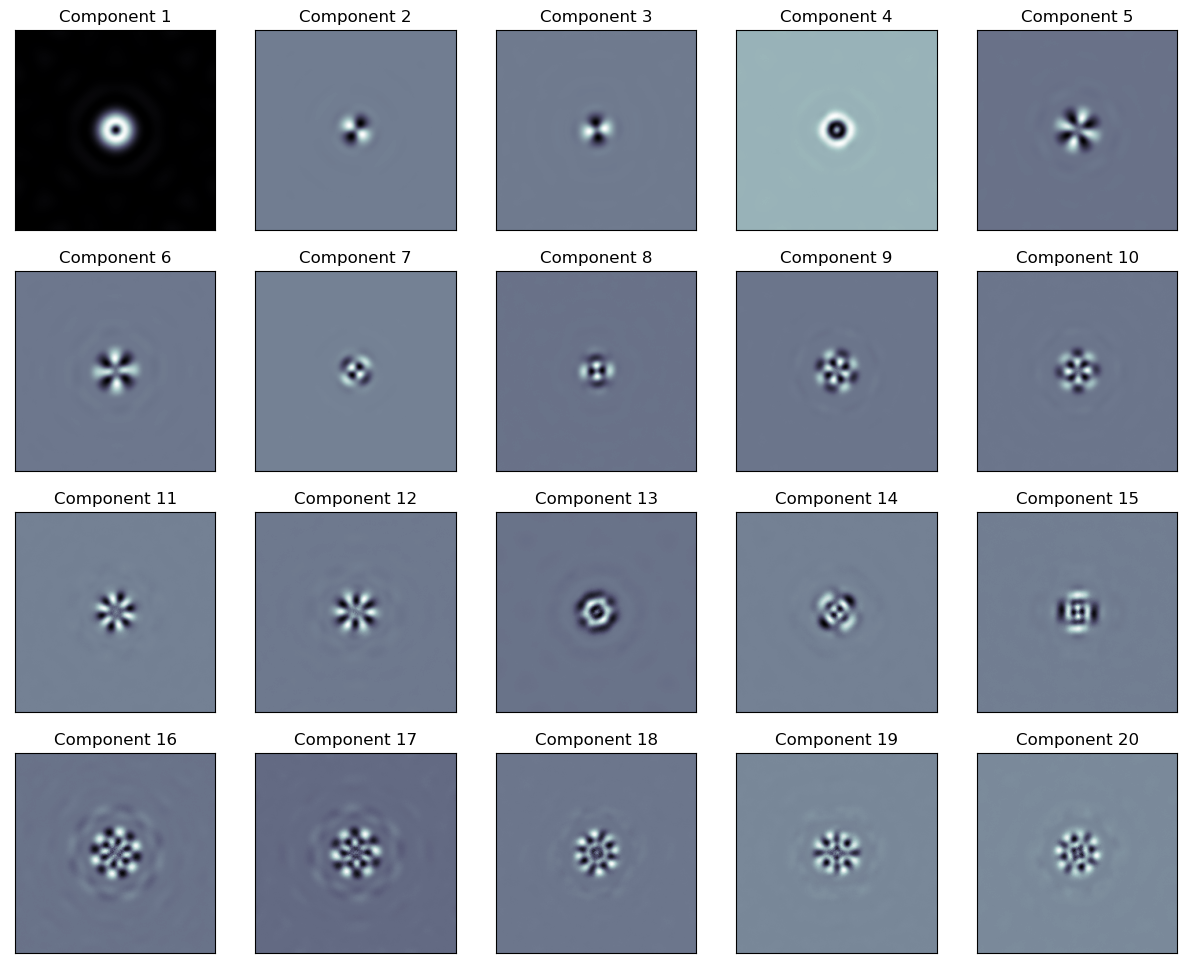

In [38]:
fig = plt.figure(figsize=(15,12))
n_rows, n_cols = 4, 5

cmap = plt.cm.bone
vmax = 10**np.round(np.log10(diffs.max()))
norm = mpl.colors.LogNorm(vmin=1., vmax=vmax, clip=True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

comps = pca.components_
for i in range(20):
    ax = fig.add_subplot(n_rows, n_cols, i + 1)
    ax.imshow(comps[i].reshape(diffs.shape[1],diffs.shape[2]),cmap=cmap)
    ax.set_title('Component {}'.format(i + 1))
    ax.set_xticks([])
    ax.set_yticks([])

Inverting the PCA reconstruction can help us visualize the quality of the PCA representation.

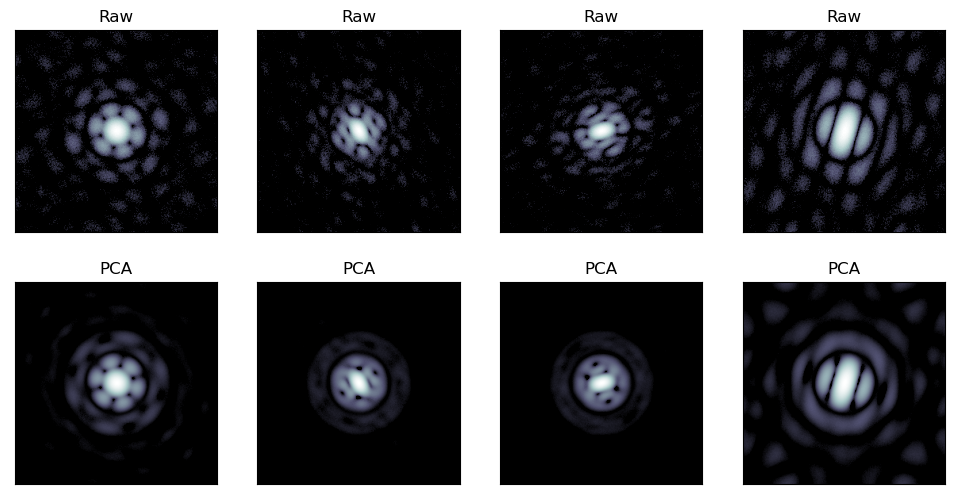

In [42]:
pca_inverse = pca.inverse_transform(pca_transform)

# Visualize pairs of raw and PCA data
fig = plt.figure(figsize=(12, 6))
n_rows, n_cols = 2, 4
vals = np.random.choice(np.arange(len(diffs)),n_cols)

for i in range(len(vals)):
    ax_raw = fig.add_subplot(n_rows, n_cols, i+1)
    ax_raw.imshow(diffs[vals[i]],cmap,norm=norm)
    ax_raw.set_xticks([])
    ax_raw.set_yticks([])
    ax_raw.set_title('Raw')
    
    ax_pca = fig.add_subplot(n_rows, n_cols, i + 5)
    ax_pca.imshow(pca_inverse[vals[i]].reshape(diffs.shape[1],diffs.shape[2]),cmap,norm=norm)
    ax_pca.set_xticks([])
    ax_pca.set_yticks([])
    ax_pca.set_title('PCA')

### Questions:
Redo the PCA decomposition with fewer components (for example 3 or 4).  
- What happens to the Inverse transforms?  
- How do these compare the inverse with more components?  
- How do they compare to the original diffraction data?


## Visualizing the distribution of data
Now that we've visualized the principal components and found that the components correspond to specific features of the diffraction data, we can also plot the principal component coefficients for the whole dataset to see if any trends appear.

Below, we plot the first and second component coefficient for each datapoint, and color the points by the number of particles in the image.  

We can see that the data corresponding to a single particle appear as a single dense point far away from the rest of the data.  This makes sense, since all scattering patterns from single particles should be identical with spherical symmetry.  

Images with two particles appear as a sharp vertical line, and data with increasing particle numbers appear as more diffuse lines

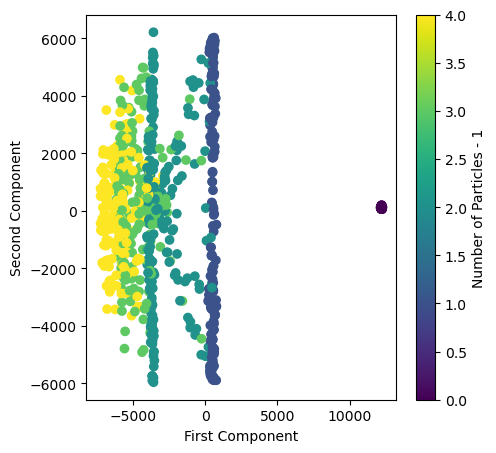

In [49]:
fig, ax = plt.subplots(figsize=(5,5))
p = ax.scatter(pca_transform[:,0],pca_transform[:,1],c=targets)
cbar = fig.colorbar(p,ax=ax)
ax.set_xlabel('First Component')
ax.set_ylabel('Second Component')
cbar.set_label('Number of Particles - 1')

### Questions:
- How can we interpret the fact that diffraction data appear as vertical lines in this reduced space?
- What does it mean that we see data move towards low First Component values as the number of particles increase?

### It may also be interesting to see how the data varies with differnt components
We can start from the mean of the PCA space, which represents the "average diffraction pattern" for the whole dataset.  From here, we can vary components 1 and 2, invert the transform, and see how the data changes.

In [58]:
d = pca.inverse_transform(np.mean(pca_transform,axis=0)).reshape(diffs.shape[1],diffs.shape[2])

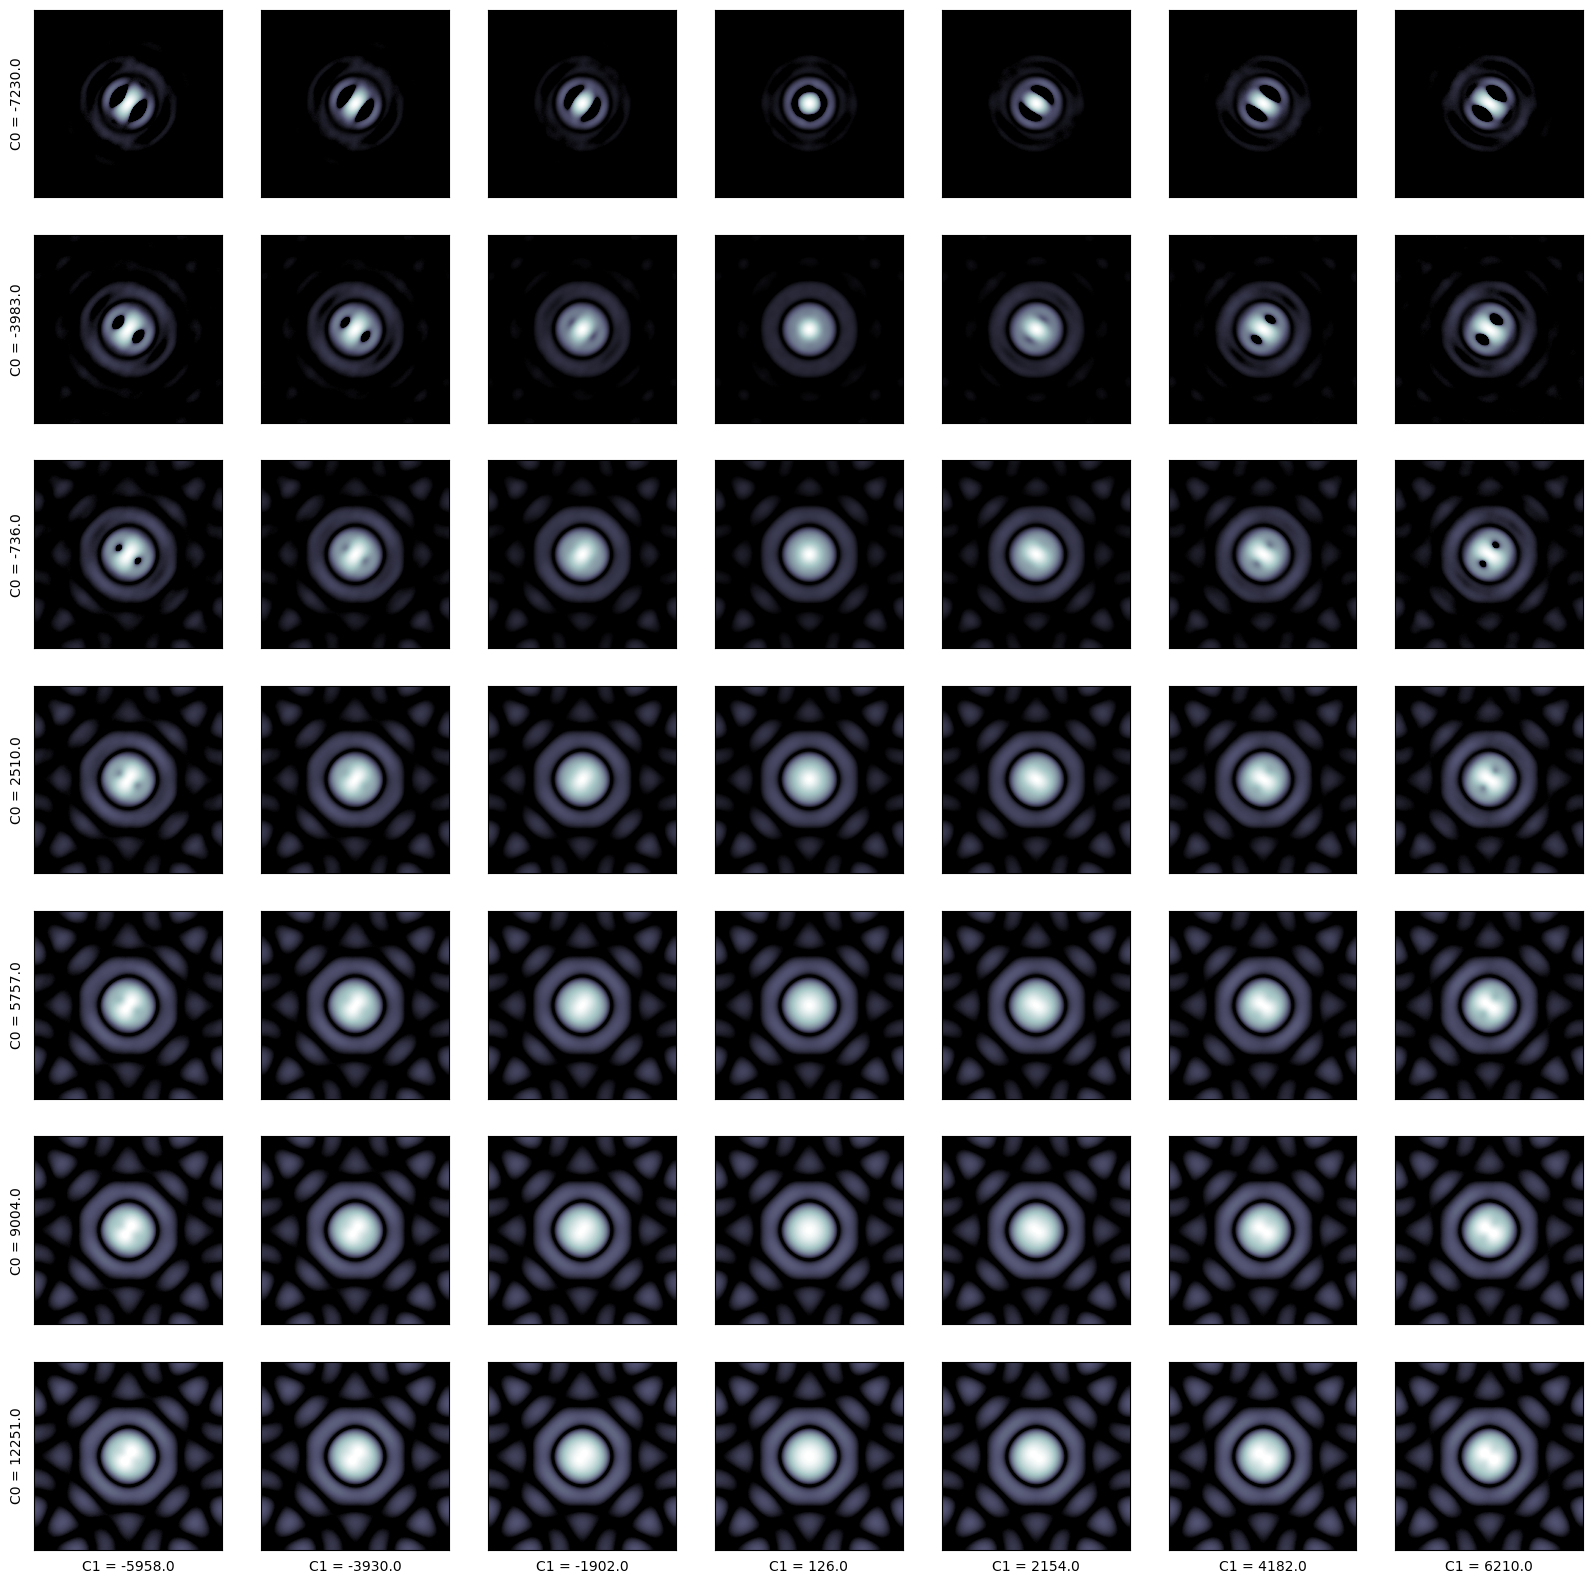

In [67]:
n_steps = 7
range_1 = np.linspace(np.min(pca_transform[:,0]),np.max(pca_transform[:,0]),n_steps)
range_2 = np.linspace(np.min(pca_transform[:,1]),np.max(pca_transform[:,1]),n_steps)

fig = plt.figure(figsize=(20,20))
n_rows, n_cols = n_steps, n_steps

mean_pca = np.mean(pca_transform,axis=0)

n = 1
for i in range(len(range_1)):
    for j in range(len(range_2)):
        d = mean_pca.copy()
        d[0] = range_1[i]
        d[1] = range_2[j]
        
        im = pca.inverse_transform(d).reshape(diffs.shape[1],diffs.shape[2])
        
        ax = fig.add_subplot(n_rows, n_cols, n)
        ax.imshow(im,cmap,norm=norm)
        ax.set_xticks([])
        ax.set_yticks([])
        
        if j == 0:
            ax.set_ylabel('C0 = {}'.format(np.round(range_1[i])))
        if i == len(range_1) - 1:
            ax.set_xlabel('C1 = {}'.format(np.round(range_2[j])))
            
        
        n += 1

### Questions:
- What can we learn about the data based on looking at how the first two components influence the diffraction data?
- Based on our understanding of the data distribution, what issues can we expect for classifying the data?

## Part A: Image classification with convolutional neural networks (CNNs)

### Use ChatGPT to build a simple CNN classifier
We will use the `PyTorch` library to build and train a neural network classifier. Let's use ChatGPT to recommend a neural network architecture for classifying the diffraction patterns into one of five classes.

#### ChatGPT Prompt:
Make a neural network model in PyTorch that classifies $N \times N$ grayscale images into 5 classes.

In [20]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, N):
        super(SimpleCNN, self).__init__()

        # Assuming grayscale image so input channels = 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=64 * (N//4) * (N//4), out_features=128)  # after two max-pooling layers
        self.fc2 = nn.Linear(in_features=128, out_features=5)  # 5 classes
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)

        x = self.relu(self.conv2(x))
        x = self.maxpool(x)

        x = x.view(x.size(0), -1)  # flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
print(SimpleCNN(N))

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=262144, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
)


### Prepare data for training
Split our data into training, validation, and testing datasets and define data loaders for feeding data to the model in smaller batches.

In [21]:
from torch.utils.data import DataLoader, TensorDataset, random_split

torch.set_default_dtype(torch.float64)

# Define sizes of the training, validation, and testing datasets as well as batch size
val_size = int(0.1 * num_images)
test_size = int(0.1 * num_images)
train_size = num_images - val_size - test_size
batch_size = 32

# Convert arrays to torch tensors; note the insertion of an extra dimension - the channel dimension - for convolution
dataset = TensorDataset(torch.from_numpy(diffs).unsqueeze(1), torch.from_numpy(targets))
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Format dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Use ChatGPT to write a training loop for the CNN
Let's use ChatGPT to recommend the training protocol for the CNN; for example, what loss function, optimizer, learning rate, and number of iterations (epochs) to use as a starting point. We can also ask for the loss to be recorded after each epoch in order to inspect the training history.

#### ChatGPT Prompt:
Write the training loop to optimize the CNN, which displays a progress bar and prints the current accuracy on the training and validation datasets for each epoch. Also save the training and validation losses and accuracies at each epoch to lists.

In [138]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(N).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [139]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Progress bar with tqdm
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    train_accuracy = correct_train / total_train
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Evaluate on validation data
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    print(f"Training Loss: {train_losses[-1]:.3f}, Training Accuracy: {train_accuracy*100:.2f}%,",
          f"Validation Loss: {val_losses[-1]:.3f}, Validation Accuracy: {val_accuracy*100:.2f}%")

Epoch 1/10: 100%|███████████████████████████████| 25/25 [00:05<00:00,  4.68it/s]


Training Loss: 22.630, Training Accuracy: 44.62%, Validation Loss: 0.829, Validation Accuracy: 62.00%


Epoch 2/10: 100%|███████████████████████████████| 25/25 [00:05<00:00,  4.69it/s]


Training Loss: 0.641, Training Accuracy: 73.00%, Validation Loss: 0.694, Validation Accuracy: 62.00%


Epoch 3/10: 100%|███████████████████████████████| 25/25 [00:05<00:00,  4.69it/s]


Training Loss: 0.435, Training Accuracy: 82.38%, Validation Loss: 0.357, Validation Accuracy: 85.00%


Epoch 4/10: 100%|███████████████████████████████| 25/25 [00:05<00:00,  4.70it/s]


Training Loss: 0.332, Training Accuracy: 85.88%, Validation Loss: 0.953, Validation Accuracy: 59.00%


Epoch 5/10: 100%|███████████████████████████████| 25/25 [00:05<00:00,  4.71it/s]


Training Loss: 0.331, Training Accuracy: 86.25%, Validation Loss: 0.362, Validation Accuracy: 84.00%


Epoch 6/10: 100%|███████████████████████████████| 25/25 [00:05<00:00,  4.71it/s]


Training Loss: 0.210, Training Accuracy: 92.25%, Validation Loss: 0.284, Validation Accuracy: 82.00%


Epoch 7/10: 100%|███████████████████████████████| 25/25 [00:05<00:00,  4.70it/s]


Training Loss: 0.178, Training Accuracy: 93.62%, Validation Loss: 0.326, Validation Accuracy: 82.00%


Epoch 8/10: 100%|███████████████████████████████| 25/25 [00:05<00:00,  4.69it/s]


Training Loss: 0.142, Training Accuracy: 94.50%, Validation Loss: 0.330, Validation Accuracy: 81.00%


Epoch 9/10: 100%|███████████████████████████████| 25/25 [00:05<00:00,  4.69it/s]


Training Loss: 0.106, Training Accuracy: 96.88%, Validation Loss: 0.264, Validation Accuracy: 88.00%


Epoch 10/10: 100%|██████████████████████████████| 25/25 [00:05<00:00,  4.68it/s]


Training Loss: 0.083, Training Accuracy: 97.25%, Validation Loss: 0.288, Validation Accuracy: 86.00%


### Evaluate the trained model

The first assessment we can make is whether the model is under- or overfit to the training data. We can start by plotting the evolution of the training and validation loss and accuracy over the course of training. A good stopping point to avoid overfitting is when the validation loss stops decreasing.

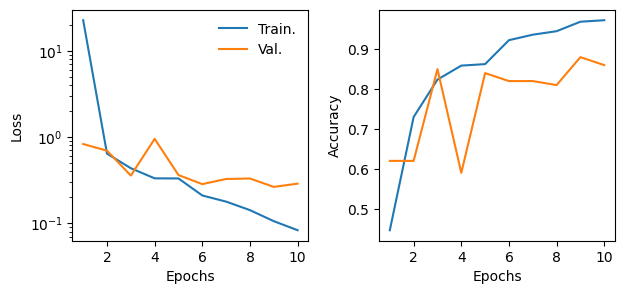

In [140]:
fig, ax = plt.subplots(1,2, figsize=(7,3))
fig.subplots_adjust(wspace=0.3)
ax[0].plot(range(1, len(train_losses) + 1), train_losses, label='Train.')
ax[0].plot(range(1, len(val_losses) + 1), val_losses, label='Val.')
ax[0].set_yscale('log')

ax[1].plot(range(1, len(train_accuracies) + 1), train_accuracies)
ax[1].plot(range(1, len(val_accuracies) + 1), val_accuracies)

ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy');

Notice that ChatGPT selected the cross-entropy loss criterion to optimize the CNN. This is a common choice for classification problems, and is defined on each data point as,
$$ \mathcal{L}_{CE} = -\sum_{i=1}^{n}t_i \log{p_i},$$
where $n$ is the total number of classes, $t_i$ gives the true class (*i.e.* is equal to 1 when $i$ is the true class and zero otherwise), and $p_i$ is the softmax probability for the $i^{th}$ class predicted by the neural network.

**Note:** `PyTorch` defines its cross-entropy loss between the target and predicted *logits* as opposed to softmax probabilities. This means that to obtain the probabilities associated with the outputs of our neural network, we need to apply the softmax function to the ouputs ourselves.

Let's evaluate the CNN on the held-out testing dataset and inspect both the predicted classes and associated probabilities for each data point. We can borrow a lot of the code structure from the evaluation portion of the training loop proposed by ChatGPT.

In [102]:
# Evaluate and save class probabilities and predictions on testing data
test_targets = targets[test_dataset.indices]
test_objs = objs[test_dataset.indices]
test_diffs = diffs[test_dataset.indices]

model.eval()
test_probabilities = []
test_predictions = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        test_probabilities += nn.Softmax(1)(outputs)[np.arange(len(inputs)), predicted].cpu().tolist()
        test_predictions += predicted.cpu().tolist()
        
test_probabilities = np.array(test_probabilities)
test_predictions = np.array(test_predictions)

Let's compare the predicted probabilities for correctly and incorrectly classified examples.

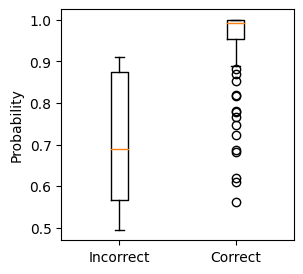

In [135]:
# Boxplots of predicted probabilities for correctly and incorrectly classified examples
correct = test_predictions == test_targets
incorrect = test_predictions != test_targets

fig, ax = plt.subplots(figsize=(3,3))
ax.boxplot((test_probabilities[incorrect], test_probabilities[correct]))
ax.set_xticks([1,2])
ax.set_xticklabels(['Incorrect', 'Correct'])
ax.set_ylabel('Probability');

Another helpful assessment tool is the confusion matrix. Each entry $C_{i,j}$ of the confusion matrix gives the number of examples belonging to class $i$ that are classified as $j$.

In [133]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_targets, test_predictions):
    cm = confusion_matrix(test_targets, test_predictions, labels=range(5))
    
    fig, ax = plt.subplots(1,2, figsize=(3.15,3), gridspec_kw={'width_ratios': [1,0.05]})
    fig.subplots_adjust(wspace=0.1)

    cmap = plt.cm.bone
    vmax = cm.max()
    norm = plt.Normalize(vmin=0, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

    ax[0].imshow(cm, cmap=cmap, norm=norm)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i,j] < 0.2*cm.max():
                color = 'white'
            else:
                color = 'black'
            ax[0].text(j,i, cm[i,j], ha='center', va='center', color=color)

    ax[0].set_xticks(range(5))
    ax[0].set_xticklabels(range(1,6))
    ax[0].set_yticks(range(5))
    ax[0].set_yticklabels(range(1,6))
    ax[0].set_xlabel('Predicted aggregate size')
    ax[0].set_ylabel('True aggregate size')
    
    plt.colorbar(sm, cax=ax[1])

    return fig

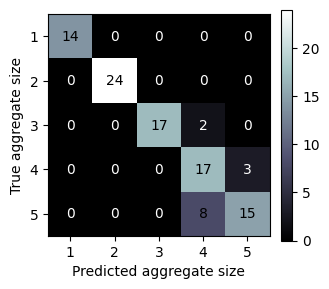

In [134]:
fig = plot_confusion_matrix(test_targets, test_predictions)

Finally, we can also plot the images of the underlying objects to visualize which configurations were most difficult to classify.

In [ ]:
def plot_object_grid(objs, labels=None):
    fig, ax = plt.subplots(4,4, figsize=(8,8))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    axes = ax.ravel()
    
    if len(objs) <= 16:
        indices = np.arange(len(objs))
    else:
        indices = np.random.randint(len(objs), size=16)

    for i, index in enumerate(indices):
        axes[i].imshow(objs[index], origin='lower', cmap='gray')
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    
    for j in range(i + 1,16):
        axes[j].remove()
        
    try: len(labels)
    except: pass
    else:
        for i, index in enumerate(indices):
            axes[i].text(0.9, 0.1, 'n = ' + str(labels[index]), color='white', ha='right', va='bottom',
                         transform=axes[i].transAxes)
    return fig

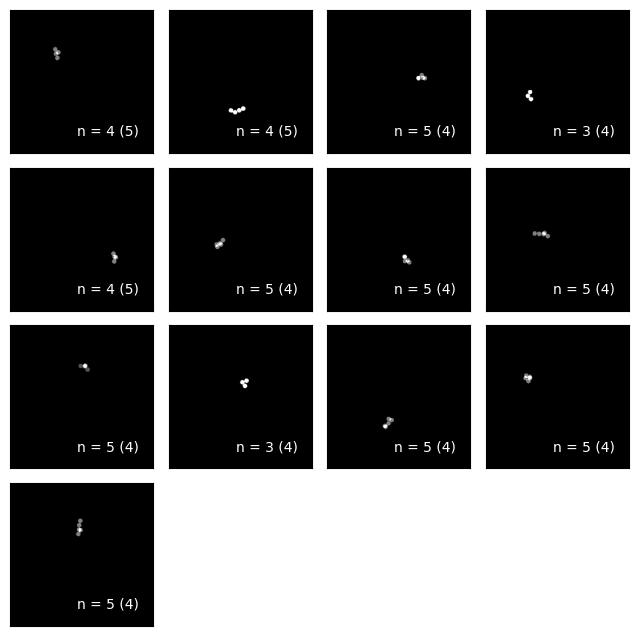

In [76]:
# Plot a grid of examples with labels denoting the true (predicted) aggregate size
labels = [str(i) + ' (' + str(j) + ')' for (i,j) in zip(test_targets[incorrect] + 1, test_predictions[incorrect] + 1)]
fig = plot_object_grid(test_objs[incorrect], labels)

### Questions
- How do modifications to the model architecture affect performance; for instance, changing the dropout rate, including additional convolution and pooling layers, etc.?
- How does the amount of simulated noise affect the classification accuracy?
- The bigger the aggregate size, the more variations we can observe in the diffraction patterns due to reduced rotational symmetry. What are some strategies to account for this imbalance between the different class labels?